
# Task 1 - Load parcel; Extract scalar attribute; Plot histogram

In [2]:
import shapefile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import rasterio


In [3]:
sf = shapefile.Reader('parcels_exam.shp')

In [4]:
#grab the shapefile's field names (omit the first psuedo field)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write the records into a dataframe
sh_df = pd.DataFrame(columns=fields, data=records)

#add the coordinate data to a column called "coords"
sh_df = sh_df.assign(coords=shps)

In [5]:
sh_df.head()

,_id,area,water,ponding,organic,slope,gdd,road,tot_price,coords
0,0,212202.777883,0.470132,0.716075,0.287991,0.383462,0.749170,0.878452,2.096351e+07,"[(-2126055.914236194, 1782007.052652219), (-21..."
1,1,115054.634691,0.311945,0.398221,0.209844,0.186193,0.944372,0.739551,6.928590e+06,"[(-2125540.6725971815, 1742579.3279602642), (-..."
2,2,308655.040738,0.555649,0.009240,0.833038,0.984329,0.703495,0.181631,3.277608e+07,"[(-2091681.9641146532, 1748159.6261059537), (-..."
3,3,204126.947941,0.277596,0.128861,0.392676,0.956406,0.187131,0.903984,2.003098e+07,"[(-2089203.1341303517, 1764248.6226340423), (-..."
4,4,337687.699386,0.374245,0.324405,0.680116,0.795535,0.503934,0.296242,2.981107e+07,"[(-2087013.9857393645, 1758534.1178913135), (-..."


In [6]:
#check if there is null value
sh_df.isnull().sum()

_id          0
area         0
water        0
ponding      0
organic      0
slope        0
gdd          0
road         0
tot_price    0
coords       0
dtype: int64

In [7]:
#calculate 'price per area'
sh_df['price_per_area'] = sh_df['tot_price']/sh_df['area']

In [8]:
print(sh_df.head(10))
print(sh_df.shape)

   _id           area     water   ponding   organic     slope       gdd  \
0    0  212202.777883  0.470132  0.716075  0.287991  0.383462  0.749170   
1    1  115054.634691  0.311945  0.398221  0.209844  0.186193  0.944372   
2    2  308655.040738  0.555649  0.009240  0.833038  0.984329  0.703495   
3    3  204126.947941  0.277596  0.128861  0.392676  0.956406  0.187131   
4    4  337687.699386  0.374245  0.324405  0.680116  0.795535  0.503934   
5    5  267802.808749  0.519952  0.693956  0.090886  0.227760  0.410302   
6    6  235248.492041  0.564064  0.956933  0.113486  0.272229  0.082058   
7    7  329809.412123  0.432984  0.528234  0.349440  0.781480  0.751022   
8    8  297184.603391  0.205566  0.535468  0.437814  0.974990  0.300824   
9    9  314015.304961  0.817339  0.473143  0.882284  0.733289  0.409726   

       road     tot_price                                             coords  \
0  0.878452  2.096351e+07  [(-2126055.914236194, 1782007.052652219), (-21...   
1  0.739551  6

Text(0,0.5,'Frequency')

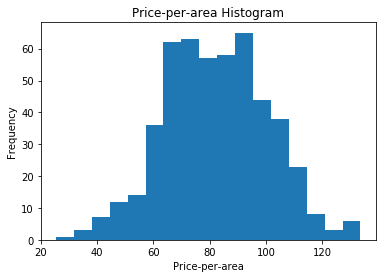

In [9]:
#create histogram for 'price per area'
plt.hist(sh_df['price_per_area'],bins='auto')
plt.title('Price-per-area Histogram')
plt.xlabel('Price-per-area')
plt.ylabel('Frequency')

# Task 2 - Valuation Model with scalar attributes

In [10]:
# 1. drop 'coords' since it's not a scalar attribute
# 2. drop 'tot_price' since 'price_per_area' will be used as target Y
# 3. drop '-id' since it's not useful
# sh_df.columns

In [57]:
# #test corr
# d2 = sh_df.drop(columns = ['_id','coords'])
# m2 = d2.corr()
# m2['tot_price'].sort_values(ascending = False)

tot_price         1.000000
area              0.885017
price_per_area    0.750071
ponding           0.129602
organic           0.106254
gdd               0.075735
road              0.058080
water             0.049341
slope             0.032900
Name: tot_price, dtype: float64

In [11]:
df_scalar = sh_df.drop(columns = ['_id','tot_price','coords'])
df_scalar.head(5)

,area,water,ponding,organic,slope,gdd,road,price_per_area
0,212202.777883,0.470132,0.716075,0.287991,0.383462,0.749170,0.878452,98.79
1,115054.634691,0.311945,0.398221,0.209844,0.186193,0.944372,0.739551,60.22
2,308655.040738,0.555649,0.009240,0.833038,0.984329,0.703495,0.181631,106.19
3,204126.947941,0.277596,0.128861,0.392676,0.956406,0.187131,0.903984,98.13
4,337687.699386,0.374245,0.324405,0.680116,0.795535,0.503934,0.296242,88.28


In [12]:
# There are only 7 input features so feature selection may not be necessary in this case. But I'll be doing 
# variable analysis below nonethesless as if there are 100 features.

In [13]:
# min-max normalization
mea = np.mean(df_scalar)
rang = np.max(df_scalar) - np.min(df_scalar)
df_scalar_norm = (df_scalar - mea)/rang
df_scalar_norm.head(5)

,area,water,ponding,organic,slope,gdd,road,price_per_area
0,-0.049846,-0.022080,0.215780,-0.227536,-0.131054,0.236632,0.403051,0.152355
1,-0.382859,-0.180920,-0.103384,-0.305967,-0.328668,0.432760,0.262898,-0.204147
2,0.280782,0.063791,-0.493968,0.319496,0.470864,0.190740,-0.300049,0.220753
3,-0.077529,-0.215411,-0.373855,-0.122470,0.442892,-0.328073,0.428812,0.146255
4,0.380303,-0.118363,-0.177504,0.166017,0.281740,-0.009768,-0.184405,0.055211


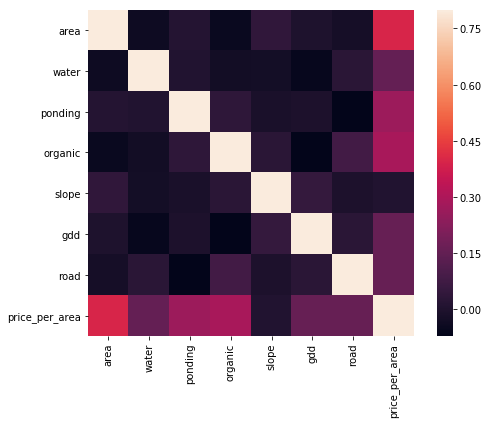

In [14]:
#plotting correlation with heatmap
matrix = df_scalar_norm.corr()
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(matrix, vmax=0.8, square = True)

#surprisingly, gdd and slope don't have high correlation with price-per-area

In [15]:
# listing out correlation with 'price_per_area' in order
feature = matrix['price_per_area'].sort_values(ascending = False)
feature = feature[feature.index != 'price_per_area']
feature

area       0.395904
organic    0.291332
ponding    0.269178
gdd        0.160012
road       0.157440
water      0.153888
slope      0.006206
Name: price_per_area, dtype: float64

In [16]:
# Training Random Forest Regressor
pred = list(feature.index)
target = 'price_per_area'
X = df_scalar_norm[pred]
Y = df_scalar_norm[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

#there doesn't appear to be much difference between 100 trees and 10 trees
#if n_estimator < 10, then the model becomes biased or underfit and error will increase 
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

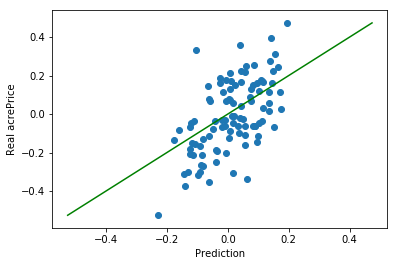

In [17]:
# Make prediction with trained regressor and visualize discrepancy between prediction and real price
Y_pred = model.predict(X_test)

plt.scatter(Y_pred, Y_test)
plt.xlabel('Prediction')
plt.ylabel('Real acrePrice')

perfectLine = np.linspace(np.min(Y_test), np.max(Y_test), 100)
plt.plot(perfectLine, perfectLine, '-g')
plt.show()


In [18]:
# compute mean_squared_error
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_pred)

0.023639036959828635

# Task 3 - Incorporate parcel geometries into model

In [82]:
#Just poking around to understand more about coordinates...
# coords appears contain all (x,y) points needed to specify a shape 
# sh_df['coords'][0]

# print(len(sh_df['coords'][0]))
# print(len(sh_df['coords'][1]))

# different number of points are used in coords
# print(sh_df['coords'][0])
# print('\n')
# print(sh_df['coords'][1])

[(-2126055.914236194, 1782007.052652219), (-2126123.5810968173, 1782223.3234849542), (-2126134.680315325, 1782343.2096728592), (-2126034.6143737948, 1782580.6883616173), (-2125957.518820213, 1782589.190666593), (-2125809.348663279, 1782529.7241628568), (-2125717.140125162, 1782389.7431134176), (-2125635.40281591, 1782071.1597750727), (-2125669.85080682, 1782051.3061248835), (-2125951.84984425, 1782013.4312285504), (-2126055.914236194, 1782007.052652219)]


[(-2125540.6725971815, 1742579.3279602642), (-2125531.525086078, 1742431.339366743), (-2125556.049590267, 1742567.2572634367), (-2125570.205447589, 1742610.14189409), (-2125423.130571558, 1742615.3011019225), (-2125540.6725971815, 1742579.3279602642), (-2125207.6929388223, 1742077.555683562), (-2125317.719616254, 1742091.055118847), (-2125386.031601641, 1742099.9525231163), (-2125284.004426814, 1742201.188018668), (-2125239.0796179753, 1742317.3033871036), (-2125308.9618981616, 1742412.398311656), (-2125285.7464306667, 1742450.372817

In [19]:
# features(continuous) that can be used for measuring convex-ness
# 1. land_to_convex_ratio = (polygon area by existing coords)/(convex hull area)
#    a more convex-ed parcel would probably have higher ratio.
# 2. num_points = number of points needed to describe the shape
#    a more convex-ed parcel would probably need fewer points.
# 3.(not implementd) concave_to_convex_ratio = (concave hull area)/(convex hull area)
#    this should work better than #1? but it will take quiet a bit time to develop concave algorithm since shapely 
#    only contains convex function

def get_poly_area(coordinates):
    return Polygon(coordinates).area
sh_df['polygon_area']= sh_df['coords'].apply(get_poly_area)

def get_convex_area(coordinates):
    return Polygon(coordinates).convex_hull.area
sh_df['convex_area']= sh_df['coords'].apply(get_convex_area)

def get_num_points(coordinates):
    return len(coordinates)
sh_df['num_points']= sh_df['coords'].apply(get_num_points)

sh_df['land_to_convex_ratio'] = sh_df['polygon_area']/sh_df['convex_area']

sh_df.head(5)

,_id,area,water,ponding,organic,slope,gdd,road,tot_price,coords,price_per_area,polygon_area,convex_area,num_points,land_to_convex_ratio
0,0,212202.777883,0.470132,0.716075,0.287991,0.383462,0.749170,0.878452,2.096351e+07,"[(-2126055.914236194, 1782007.052652219), (-21...",98.79,212202.777883,212202.777883,11,1.000000
1,1,115054.634691,0.311945,0.398221,0.209844,0.186193,0.944372,0.739551,6.928590e+06,"[(-2125540.6725971815, 1742579.3279602642), (-...",60.22,115054.634691,214637.869507,20,0.536041
2,2,308655.040738,0.555649,0.009240,0.833038,0.984329,0.703495,0.181631,3.277608e+07,"[(-2091681.9641146532, 1748159.6261059537), (-...",106.19,308655.040738,308655.040738,5,1.000000
3,3,204126.947941,0.277596,0.128861,0.392676,0.956406,0.187131,0.903984,2.003098e+07,"[(-2089203.1341303517, 1764248.6226340423), (-...",98.13,204126.947941,297176.441461,24,0.686888
4,4,337687.699386,0.374245,0.324405,0.680116,0.795535,0.503934,0.296242,2.981107e+07,"[(-2087013.9857393645, 1758534.1178913135), (-...",88.28,337687.699386,337687.699386,5,1.000000


In [20]:
# drop columns that won't be used as features
df_scalar = sh_df.drop(columns = ['_id','coords','tot_price','polygon_area','convex_area'])

# min-max normalization for dataframe with newly constructed features
mea = np.mean(df_scalar)
rang = np.max(df_scalar) - np.min(df_scalar)
df_scalar_norm = (df_scalar - mea)/rang
df_scalar_norm.head(5)

,area,water,ponding,organic,slope,gdd,road,price_per_area,num_points,land_to_convex_ratio
0,-0.049846,-0.022080,0.215780,-0.227536,-0.131054,0.236632,0.403051,0.152355,-0.168061,0.181994
1,-0.382859,-0.180920,-0.103384,-0.305967,-0.328668,0.432760,0.262898,-0.204147,0.104667,-0.295866
2,0.280782,0.063791,-0.493968,0.319496,0.470864,0.190740,-0.300049,0.220753,-0.349879,0.181994
3,-0.077529,-0.215411,-0.373855,-0.122470,0.442892,-0.328073,0.428812,0.146255,0.225879,-0.140499
4,0.380303,-0.118363,-0.177504,0.166017,0.281740,-0.009768,-0.184405,0.055211,-0.349879,0.181994


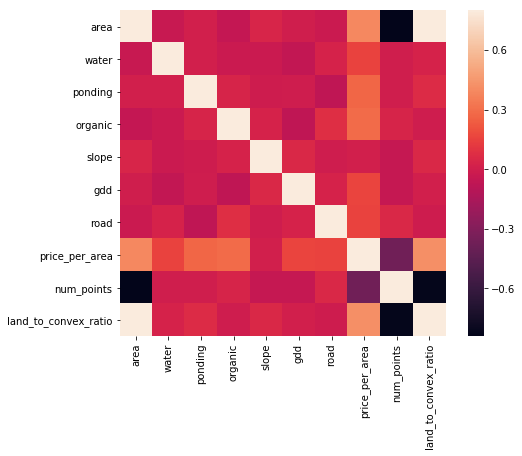

In [21]:
# re-compute correlation and redraw heatmap
matrix = df_scalar_norm.corr()
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(matrix, vmax=0.8, square = True)

In [22]:
#re-print correlation list
feature = matrix['price_per_area'].sort_values(ascending = False)
feature = feature[feature.index != 'price_per_area']
feature

#the two newly added features (land_to_convex_ratio and num_points) has strongest correlations with 
#price-per-target out of all features. However, the correlation is still between weak to moderate (between 0.3 and 0.5) 

land_to_convex_ratio    0.421613
area                    0.395904
organic                 0.291332
ponding                 0.269178
gdd                     0.160012
road                    0.157440
water                   0.153888
slope                   0.006206
num_points             -0.372374
Name: price_per_area, dtype: float64

In [23]:
#re-train random forest regressor
pred = list(feature.index)
target = 'price_per_area'
X = df_scalar_norm[pred]
Y = df_scalar_norm[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

#there doesn't appear to be much difference between 100 trees and 10 trees
#if n_estimator < 10, then the model becomes biased or underfit and error will increase 
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

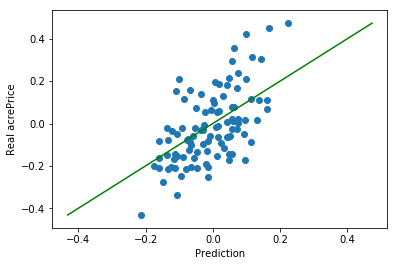

In [24]:
#re-draw comparison scatter plot
Y_pred = model.predict(X_test)

plt.scatter(Y_pred, Y_test)
plt.xlabel('Prediction')
plt.ylabel('Real acrePrice')

perfectLine = np.linspace(np.min(Y_test), np.max(Y_test), 100)
plt.plot(perfectLine, perfectLine, '-g')
plt.show()

#the prediction looks a little closer to real price now

In [25]:
# compute mean_squared_error
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_pred)

#square error is better than previous model (>0.0236)

0.018360983810529852

# Task 4 - Join CDL to parcel and incorporate crop type into model

In [30]:
#overlay parcels onto CDL raster
from rasterio.mask import mask
with rasterio.open('CDL_2017_clip_20180808132906_1114279202.tif') as dataset:
    masked, out_transform = mask(dataset, sh_df['coords'].apply(Polygon), crop=True, invert=False)
    out_meta = dataset.meta.copy()

out_meta.update({'height':masked.shape[1],'width':masked.shape[2],'transform':out_transform})

with rasterio.open('masked.tif','w', **out_meta) as dest:
    dest.write(masked)

In [31]:
# out_transform
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 2918,
 'height': 1506,
 'count': 1,
 'crs': CRS({'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}),
 'transform': Affine(30.0, 0.0, -2134335.0,
        0.0, -30.0, 1783365.0)}

In [32]:
#since inverted = False, only pixels inside of parcels will have non-zero values. Most values would be 0.
masked

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [33]:
#there are 1506*2918 = 439,4508 pixels in the overlaid raster
masked.shape

(1, 1506, 2918)

In [34]:
# count number of pixels for land types in overlaid raster
unique, counts = np.unique(masked, return_counts=True)
occurance = pd.DataFrame(columns = ['cdl_code','counts'])
occurance['cdl_code'] = unique
occurance['counts'] = counts
occurance = occurance.sort_values(by = 'counts', ascending = False)
occurance.head(5)

,cdl_code,counts
0,0,4270578
18,69,22968
21,75,19004
15,61,10637
22,76,7977


In [35]:
# decipher cdl_code into land type names and calculate percentage of each land types in overlaid raster
cdl_map = pd.read_csv('cdl_mapping.csv')
land_type_count = occurance.merge(cdl_map, left_on='cdl_code', right_on='cdl_code', how = 'left')
land_type_count['percent'] = 100*land_type_count['counts']/sum(land_type_count['counts'])
land_type_count.head(5)

,cdl_code,counts,land_cover,percent
0,0,4270578,undefined,97.179889
1,69,22968,grapes,0.522652
2,75,19004,almonds,0.432449
3,61,10637,fallow_idle_cropland,0.242052
4,76,7977,walnuts,0.181522
